In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"
FOLDS = [0,1,2,3,4]
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
SAMPLE = None
CONDITIONS = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

In [3]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [4]:
fold_df = pd.read_csv('/kaggle/input/5folds/5folds.csv')

In [5]:
# train_xy.head()

In [6]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)


In [7]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [8]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [9]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [10]:
# label_df[label_df.series_id.isna()]

In [11]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [12]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [13]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [14]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
17226,1538136131,Left Subarticular Stenosis,L4/L5,Severe,2,533252904,34,327.429054,312.216216,Axial T2
17231,1538136131,Right Subarticular Stenosis,L4/L5,Severe,2,533252904,34,288.515364,312.733217,Axial T2


In [15]:
# plt.imshow(img)
# plt.show()

In [16]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [17]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [18]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [19]:
# id2label

In [20]:
def gen_yolo_format(ann_df, phase='train'):
    for name, group in tqdm(ann_df.groupby(['study_id', 'series_id', 'instance_number'])):
        study_id, series_id, instance_num = name[0], name[1], name[2]
        path = f'{IMG_DIR}/{study_id}/{series_id}/{instance_num}.dcm'
        img = read_dcm(path)
        H, W = img.shape[:2]

        img_dir = os.path.join(OUT_DIR, 'images', phase)
        os.makedirs(img_dir, exist_ok=True)
        img_path = os.path.join(img_dir, f'{study_id}_{series_id}_{instance_num}.jpg')
        cv2.imwrite(img_path, img)

        ann_dir = os.path.join(OUT_DIR, 'labels', phase)
        os.makedirs(ann_dir, exist_ok=True)
        ann_path = os.path.join(ann_dir, f'{study_id}_{series_id}_{instance_num}.txt')
        
        contain_nulls = False
        
        with open(ann_path, 'w') as f:
            for i, row in group.iterrows():
                cond = row['condition']
                level = row['level']
                severity = row['label']
                if pd.isnull(severity):
                    contain_nulls = True
                    break
                class_label = f"{cond.lower().replace(' ', '_')}_{level.lower().replace('/', '_')}_{severity.lower()}"
                class_id = label2id[class_label]
                x_center = row['x'] / W
                y_center = row['y'] / H
                width = W / OD_INPUT_SIZE * STD_BOX_SIZE / W
                height = H /  OD_INPUT_SIZE * STD_BOX_SIZE / H
                f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')
        
        if not contain_nulls:
            cv2.imwrite(img_path, img)
#         break

In [21]:
for FOLD in FOLDS:
    print('Gen data fold', FOLD)
    OUT_DIR = f'data_fold{FOLD}'
    os.makedirs(OUT_DIR, exist_ok=True)
    
    train_df = filtered_df[filtered_df.fold != FOLD]
    val_df = filtered_df[filtered_df.fold == FOLD]
    
    gen_yolo_format(train_df, phase='train')
    gen_yolo_format(val_df, phase='val')

Gen data fold 0


  0%|          | 0/6621 [00:00<?, ?it/s]

  0%|          | 0/1661 [00:00<?, ?it/s]

Gen data fold 1


  0%|          | 0/6640 [00:00<?, ?it/s]

  0%|          | 0/1642 [00:00<?, ?it/s]

Gen data fold 2


  0%|          | 0/6595 [00:00<?, ?it/s]

  0%|          | 0/1687 [00:00<?, ?it/s]

Gen data fold 3


  0%|          | 0/6601 [00:00<?, ?it/s]

  0%|          | 0/1681 [00:00<?, ?it/s]

Gen data fold 4


  0%|          | 0/6671 [00:00<?, ?it/s]

  0%|          | 0/1611 [00:00<?, ?it/s]

In [22]:
#ls data_fold0

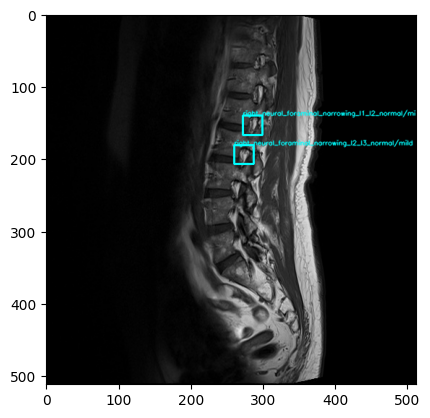

In [23]:
# # test generated annotations

_IM_DIR = f'{OUT_DIR}/images/train'
_ANN_DIR = f'{OUT_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [24]:
!zip -r -q data_fold0.zip data_fold0
!zip -r -q data_fold1.zip data_fold1
!zip -r -q data_fold2.zip data_fold2
!zip -r -q data_fold3.zip data_fold3
!zip -r -q data_fold4.zip data_fold4

In [25]:
#ls

In [26]:
!rm -rf data_fold0
!rm -rf data_fold1
!rm -rf data_fold2
!rm -rf data_fold3
!rm -rf data_fold4

In [27]:
#ls

In [28]:
#ls